In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
import scipy as sp

from scipy.signal import argrelmin, argrelmax

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Lambda, Dense, Input, Layer
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

fontP = FontProperties()
fontP.set_size(10)

In [4]:
# Check Versions
print(tf.__version__)  #1.15.0
print(keras.__version__)  #2.2.4

1.15.0
2.2.4


# Alternative DCTR fitting algorithm

The DCTR paper (https://arxiv.org/abs/1907.08209) shows how a continuously parameterized NN used for reweighting:

$f(x,\theta)=\text{argmax}_{f'}(\sum_{i\in\bf{\theta}_0}\log f'(x_i,\theta)+\sum_{i\in\bf{\theta}}\log (1-f'(x_i,\theta)))$

can also be used for fitting:

$\theta^*=\text{argmax}_{\theta'}(\sum_{i\in\bf{\theta}_0}\log f(x_i,\theta')+\sum_{i\in\bf{\theta}}\log (1-f(x_i,\theta')))$

This works well when the reweighting and fitting happen on the same 'level'.  However, if the reweighting happens at truth level (before detector simulation) while the fit happens in data (after the effects of the detector), this procedure will not work.  It works only if the reweighting and fitting both happen at detector-level or both happen at truth-level.  This notebook illustrates an alternative procedure:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_i)-\sum_{i\in\bf{\theta}}(f(x_i,\theta')/(1-f(x_i,\theta')))\log (1-g(x_i)))$

where the $f(x,\theta')/(1-f(x,\theta'))$ is the reweighting function.  The intuition of the above equation is that the classifier $g$ is trying to distinguish the two samples and we try to find a $\theta$ that makes $g$'s task maximally hard.  If $g$ can't tell apart the two samples, then the reweighting has worked!  This is similar to the minimax graining of a GAN, only now the analog of the generator network is the reweighting network which is fixed and thus the only trainable parameters are the $\theta'$.  The advantage of this second approach is that it readily generalizes to the case where the reweighting happens on a different level:

$\theta^*=\text{argmax}_{\theta'}\text{min}_{g}(-\sum_{i\in\bf{\theta}_0}\log g(x_{D,i})-\sum_{i\in\bf{\theta}}\frac{f(x_{T,i},\theta')}{(1-f(x_{T,i},\theta'))}\log (1-g(x_{D,i})))$

where $x_T$ is the truth value and $x_D$ is the detector-level value.  In simulation (the second sum), these come in pairs and so one can apply the reweighting on one level and the classification on the other.  Asympotitically, both this method and the one in the body of the DCTR paper learn the same result: $\theta^*=\theta_0$.

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the original Gaussian DCTR Example.

We will now parametrize our network by giving it a $\mu$ value in addition to $X_{i,0}\sim\mathcal{N}(\mu, 1)$ and $X_{i,1}\sim\mathcal{N}(0, \nu)$, where $\nu = (\omega_0 +\omega_1\mu)^2$ for some constant terms $\omega_0$, $\omega_1$ and $X_{i,1}$ is a secondary truth observable that will determinte detector effects for $X_{i,0}$.

First we uniformly sample $\mu$ values in some range

We then sample from normal distributions with this $\mu$ and its respective $\nu$ value.

Please note that the samples in X0 are not paired with $\mu=0$ as this would make the task trivial. 

Instead it is paired with the $\mu$ values uniformly sampled in the specified range [mu_min, mu_max].

For every value of $\mu$ in mu_values, the network sees one event drawn from $(\mathcal{N}(0,1),\mathcal{N}(0,\nu_{0}))$ and $(\mathcal{N}(\mu,1),\mathcal{N}(0,\nu_{\mu}))$, and it learns to classify them. 

i.e. we have one network that's parametrized by $\mu$ that classifies between events from $(\mathcal{N}(0,1),\mathcal{N}(0,\nu_{0}))$ and $(\mathcal{N}(\mu,1),\mathcal{N}(0,\nu_{\mu}))$, and a trained network will give us the likelihood ratio to reweight from one to another. 

## Build and Train DCTR model

In [5]:
def nu(theta, omega_0=0.7, omega_1=0.2):
    return (omega_0 + omega_1 * theta)**2

In [6]:
# Either load or train DCTR


# TDDE = Theta Dependent Detector Effects
def get_dctr(load=False, n_data_points=10**6, mu_min=-2, mu_max=2, TDDE=True):
    if load:
        json_file = open('1d_gaussian_dctr_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        dctr_model = keras.models.model_from_json(loaded_model_json)
        # load weights into new model
        dctr_model.load_weights("1d_gaussian_dctr_model.h5")
        print("Loaded model from disk")
    else:

        # Generate training & validation data
        mu_values = np.random.uniform(mu_min, mu_max, n_data_points)
        if TDDE == True:
            X0 = [(np.random.normal(0, 1), np.random.normal(0, nu(0)), mu)
                  for mu in mu_values]  # Note the zero in normal(0, 1)

            X1 = [(np.random.normal(mu, 1), np.random.normal(0, nu(mu)), mu)
                  for mu in mu_values]
        else:
            X0 = [(np.random.normal(0, 1), mu)
                  for mu in mu_values]  # Note the zero in normal(0, 1)

            X1 = [(np.random.normal(mu, 1), mu) for mu in mu_values]

        Y0 = to_categorical(np.zeros(n_data_points), num_classes=2)
        Y1 = to_categorical(np.ones(n_data_points), num_classes=2)

        X = np.concatenate((X0, X1))
        Y = np.concatenate((Y0, Y1))

        X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                            Y,
                                                            test_size=0.5)

        # Build Model
        if TDDE == True:
            inputs = Input((3, ))
        else:
            inputs = Input((2, ))
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        outputs = Dense(2, activation='softmax')(hidden_layer_3)

        dctr_model = Model(inputs=inputs, outputs=outputs)
        dctr_model.compile(loss='categorical_crossentropy',
                           optimizer='Adam',
                           metrics=['accuracy'])

        # Train Model
        earlystopping = EarlyStopping(patience=10, restore_best_weights=True)
        dctr_model.fit(X_train,
                       Y_train,
                       epochs=200,
                       batch_size=10000,
                       validation_data=(X_test, Y_test),
                       callbacks=[earlystopping],
                       verbose=0)
        print("Trained DCTR Model")

    return dctr_model

### Getting Model

In [7]:
mu_min = -2
mu_max = 2

dctr_model = get_dctr(n_data_points=10**7, mu_min=mu_min, mu_max=mu_max)
dctr_original_model = get_dctr(n_data_points=10**7,
                               mu_min=mu_min,
                               mu_max=mu_max,
                               TDDE=False)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Trained DCTR Model
Trained DCTR Model


### Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [8]:
# from NN (DCTR)
def reweight(events, param):
    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(events.shape[0], 1)) * param
    # combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)
    f = dctr_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

In [9]:
# from NN (DCTR)
def reweight_original(events, param):
    # creating tensor with same length as inputs, with theta_prime in every entry
    concat_input_and_params = K.ones(shape=(events.shape[0], 1)) * param
    # combining and reshaping into correct format:
    model_inputs = K.concatenate((events, concat_input_and_params), axis=-1)
    f = dctr_original_model(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    weights = K.expand_dims(weights, axis=1)
    return weights

## Validate DCTR for any $\mu$

### Validate for Truth Level

In [10]:
mu1 = 1.5
assert mu1 >= mu_min and mu1 <= mu_max  # choose mu1 in valid range
X0_val_T_0 = np.random.normal(0, 1, 10**6)
X0_val_T_1 = np.random.normal(0, nu(0), 10**6)
X0_val_T = np.stack((X0_val_T_0, X0_val_T_1), axis=-1)

X1_val_T_0 = np.random.normal(mu1, 1, 10**6)
X1_val_T_1 = np.random.normal(0, nu(mu1), 10**6)
X1_val_T = np.stack((X1_val_T_0, X1_val_T_1), axis=-1)

In [11]:
weights_val = reweight(tf.convert_to_tensor(X0_val_T, dtype=tf.float32), mu1)
weights_val = K.eval(weights_val)

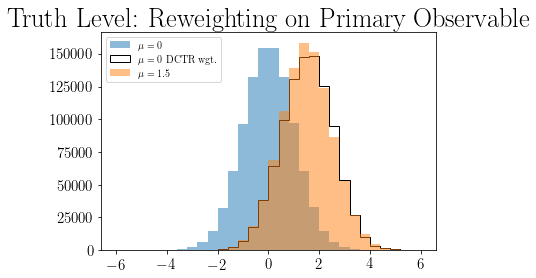

In [12]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T[:, 0], bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_T[:, 0],
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_T[:, 0], bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Truth Level: Reweighting on Primary Observable")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-Level:Reweighting-on-Primary-Observable.png")
plt.show()

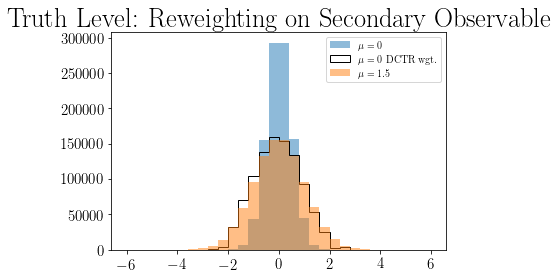

In [13]:
bins = np.linspace(-6, 6, 31)
plt.hist(X0_val_T[:, 1], bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_T[:, 1],
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_T[:, 1], bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Truth Level: Reweighting on Secondary Observable")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-Level:Reweighting-on-Secondary-Observable.png")
plt.show()

### Validate for Detector Level

To apply detector effects, each event's primary truth observable $x_{T,i,0}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,(x_{T,i,1})^2)$ ,where the square of the secondary truth observable $x_{T,i,1}$ represents the smearing. Thus: $x_{D,i} = x_{T,i,0} + Z_{i}$

In [14]:
# Generate detector level by smearing truth

X0_val_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in X0_val_T])  # Detector smearing
X1_val_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in X1_val_T])  # Detector smearing

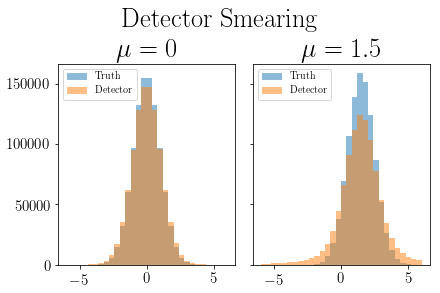

In [15]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Detector Smearing')
axs[0].set_title('$\mu=0$')
axs[0].hist(X0_val_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(X0_val_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc='upper left')
axs[1].set_title('$\mu={}$'.format(mu1))
axs[1].hist(X1_val_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(X1_val_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc='upper left')
fig.show()

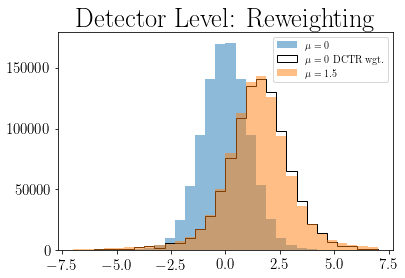

In [16]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_D,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_D, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("Detector Level: Reweighting")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Detector-Level:Reweighting.png")
plt.show()

# Alternative Fit

## Setup the dataset

We'll show the new setup with a simple Gaussian example.  Let's start by setting up the dataset.

To apply detector effects, each event's primary truth observable $x_{T,i,0}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}(0,(x_{T,i,1})^2)$ ,where the square of the secondary truth observable $x_{T,i,1}$ represents the smearing. Thus: $x_{D,i} = x_{T,i,0} + Z_{i}$

In [17]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # standard Gaussian width
# epsilon = sigma / 2  # Smearing width

theta0_T_0 = np.random.normal(theta0_param, sigma, N)  # Truth Level Data
theta0_T_1 = np.random.normal(0, nu(theta0_param), N)
theta0_T = np.stack((theta0_T_0, theta0_T_1), axis=-1)

theta0_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in theta0_T])  # Detector smearing

theta0 = np.hstack([theta0_T, np.expand_dims(theta0_D, axis=-1)])

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_T_ep = np.random.normal(0, nu(theta1_param), N)
theta1_T = np.stack((theta1_T, theta1_T_ep), axis=-1)

theta1_D = np.array([(x[0] + np.random.normal(0, x[1]**2))
                     for x in theta1_T])  # Detector smearing

theta1 = np.hstack([theta1_T, np.expand_dims(theta1_D, axis=-1)])

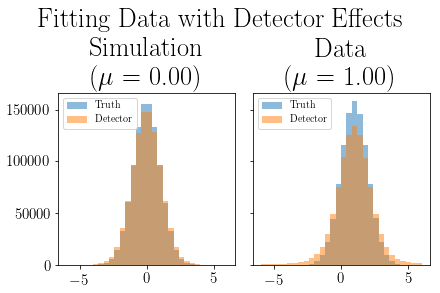

In [18]:
bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Fitting Data with Detector Effects')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc='upper left')

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc='upper left')

# fig.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Fitting-Data-with-Detector-Effects.png")
plt.show()

Notice how detector smearing is more intense for "Data".

In [19]:
labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, :2]), y_train
X_test_T, y_test_T = np.copy(X_test[:, :2]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, :2]), y_train_theta

#' Erasing' Truth level for data, we can't actually observe this
X_train[:, :2][y_train == 1], X_test[:, :2][y_test == 1] = 0., 0.
X_train_theta[:, :2][y_train_theta == 1] = 0.

# 'hiding' truth level for simulation in expected model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 2], np.hstack(
    [np.expand_dims(y_train, axis=-1), X_train[:, :2]])
X_test_D, y_test_D = X_test[:, 2], np.hstack(
    [np.expand_dims(y_test, axis=-1), X_test[:, :2]])

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.hstack(
    [np.expand_dims(y_train_theta, axis=-1), X_train_theta[:, :2]])

## Fitting Model: Scan

We'll start by showing that for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$.

### Creating Model

In [20]:
myinputs = Input(shape=(2, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model_T = Model(inputs=myinputs, outputs=predictions)
model_T.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

thetas = np.linspace(-2, 2, 17)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


### Truth Level Scan

In [21]:
def my_loss_wrapper_T(inputs,
                      val=0.,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = val

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [22]:
lvals_T = []
vlvals_T = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_T.compile(optimizer='adam',
                    loss=my_loss_wrapper_T(myinputs,
                                           theta,
                                           loss='categorical_crossentropy',
                                           batch_size=batch_size),
                    metrics=['accuracy'])

    history = model_T.fit(np.array(X_train_T),
                          y_train_T,
                          epochs=100,
                          batch_size=batch_size,
                          validation_data=(np.array(X_test_T), y_test_T),
                          verbose=0,
                          callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_T += [min_lval]
    vlvals_T += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_T)

Testing theta =  -2.0
loss:  0.07282351414114237
val_loss:  0.07284237332642078


Testing theta =  -1.75
loss:  0.10577222400158644
val_loss:  0.10561566084623336


Testing theta =  -1.5
loss:  0.1474064415320754
val_loss:  0.14733770583570002


Testing theta =  -1.25
loss:  0.19706467577815057
val_loss:  0.19689875769615173


Testing theta =  -1.0
loss:  0.25520408557355406
val_loss:  0.2549973863065243


Testing theta =  -0.75
loss:  0.3206252697110176
val_loss:  0.3205262901186943


Testing theta =  -0.5
loss:  0.3917457726597786
val_loss:  0.3914420667886734


Testing theta =  -0.25
loss:  0.46578190523386004
val_loss:  0.4653900546133518


Testing theta =  0.0
loss:  0.5357910953164101
val_loss:  0.5353732748627663


Testing theta =  0.25
loss:  0.5969846953749657
val_loss:  0.5965640022754669


Testing theta =  0.5
loss:  0.64681005692482
val_loss:  0.6465409803390503


Testing theta =  0.75
loss:  0.6796987847089767
val_loss:  0.6789721339941025


Testing theta =  1.0
loss:  0.6

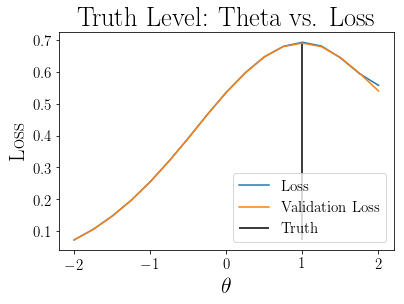

In [23]:
plt.title("Truth Level: Theta vs. Loss")
plt.plot(thetas, lvals_T, label='Loss')
plt.plot(thetas, vlvals_T, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_T),
           ymax=np.max(lvals_T),
           label='Truth')
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-Level:-Theta-vs-Loss.png")
plt.show()

In [24]:
f = sp.interpolate.interp1d(thetas, lvals_T, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999964372858


### Detector Level Scan

In [25]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model_D = Model(inputs=myinputs, outputs=predictions)
model_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


In [26]:
def my_loss_wrapper_D(val=0,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1, 2],
                        axis=1)  # sim event truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        theta_prime = val

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight(x_T, theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + (weights) * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")
        return K.mean(t_loss)

    return my_loss

In [27]:
lvals_D = []
vlvals_D = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_D.compile(optimizer='adam',
                    loss=my_loss_wrapper_D(theta,
                                           loss='categorical_crossentropy',
                                           batch_size=batch_size),
                    metrics=['accuracy'])

    history = model_D.fit(np.array(X_train_D),
                          y_train_D,
                          epochs=100,
                          batch_size=batch_size,
                          validation_data=(np.array(X_test_D), y_test_D),
                          verbose=0,
                          callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D += [min_lval]
    vlvals_D += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_D)

Testing theta =  -2.0
loss:  0.2311053888052702
val_loss:  0.23033167992532252


Testing theta =  -1.75
loss:  0.2702637853771448
val_loss:  0.2698140303194523


Testing theta =  -1.5
loss:  0.3121443809568882
val_loss:  0.3117287215590477


Testing theta =  -1.25
loss:  0.3551745256483555
val_loss:  0.3551491614282131


Testing theta =  -1.0
loss:  0.40134679213166236
val_loss:  0.4011713308095932


Testing theta =  -0.75
loss:  0.45009083941578865
val_loss:  0.44994487416744233


Testing theta =  -0.5
loss:  0.5003043256402016
val_loss:  0.5001236517727375


Testing theta =  -0.25
loss:  0.5507424605488778
val_loss:  0.5505071417093277


Testing theta =  0.0
loss:  0.5968593214154243
val_loss:  0.5965513610839843


Testing theta =  0.25
loss:  0.6351910917162895
val_loss:  0.6347260527610779


Testing theta =  0.5
loss:  0.6658702046871185
val_loss:  0.6653080371618271


Testing theta =  0.75
loss:  0.6851512874960899
val_loss:  0.6844683556556702


Testing theta =  1.0
loss:  0.6911

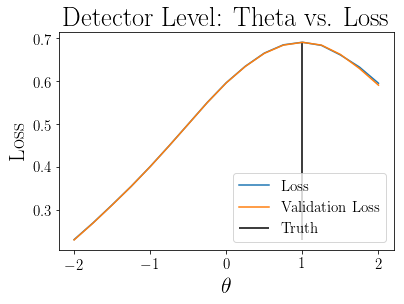

In [28]:
plt.plot(thetas, lvals_D, label='Loss')
plt.plot(thetas, vlvals_D, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D),
           ymax=np.max(lvals_D),
           label='Truth')
plt.title("Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [29]:
f = sp.interpolate.interp1d(thetas, lvals_D, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.76663538813591


### Comparison Plot

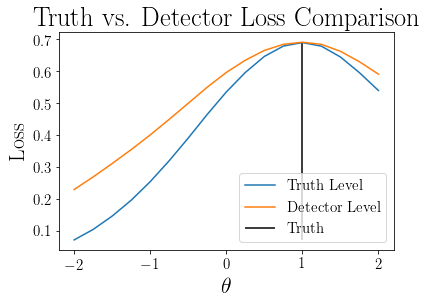

In [30]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D, label='Detector Level')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(vlvals_T + vlvals_D),
           ymax=np.max(vlvals_T + vlvals_D),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-vs-Detector-Loss-Comparison.png")
plt.show()

We've shown for fixed $\theta$, the maximum loss occurs when $\theta=\theta_1$

### Compare to Original DCTR
See how incorrect the fit is if we ignore the secondary truth observable and use the original DCTR.

In [31]:
myinputs = Input(shape=(1, ), dtype=tf.float32)
x = Dense(128, activation='relu')(myinputs)
x2 = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x2)

model_original = Model(inputs=myinputs, outputs=predictions)
model_original.summary()
batch_size = 1000

earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

thetas = np.linspace(-2, 2, 17)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               256       
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________


#### Truth Level Scan

In [32]:
def my_loss_wrapper_T_original(inputs,
                      val=0.,
                      reweight_type='DCTR',
                      loss='MSE',
                      batch_size=1000):
    x = inputs
    x = K.gather(x, np.arange(batch_size))

    theta_prime = val

    if reweight_type == 'DCTR':
        # NN (DCTR) reweight
        weights = reweight_original(x, theta_prime)
    elif reweight_type == 'analytical':
        # analytical reweight
        weights = analytical_reweight(x, theta_prime)
    else:
        raise ValueError("reweight_type must be set to 'DCTR' or 'analytical'")

    def my_loss(y_true, y_pred):
        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + weights * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss

            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")

        return K.mean(t_loss)

    return my_loss

In [33]:
lvals_T_original = []
vlvals_T_original = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_original.compile(optimizer='adam',
                           loss=my_loss_wrapper_T_original(
                               myinputs,
                               theta,
                               loss='categorical_crossentropy',
                               batch_size=batch_size),
                           metrics=['accuracy'])

    history = model_original.fit(np.array(X_train_T[:, 0]),
                          y_train_T,
                          epochs=100,
                          batch_size=batch_size,
                          validation_data=(np.array(X_test_T[:, 0]), y_test_T),
                          verbose=0,
                          callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_T_original += [min_lval]
    vlvals_T_original += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta =  -2.0
loss:  0.16739248880743982
val_loss:  0.16699077035486698


Testing theta =  -1.75
loss:  0.20556797502934931
val_loss:  0.20519686581194402


Testing theta =  -1.5
loss:  0.24972395269572734
val_loss:  0.24935947974026204


Testing theta =  -1.25
loss:  0.29967321634292604
val_loss:  0.29924769562482834


Testing theta =  -1.0
loss:  0.3539901882112026
val_loss:  0.3535039341747761


Testing theta =  -0.75
loss:  0.4119625264406204
val_loss:  0.4114200249016285


Testing theta =  -0.5
loss:  0.47198350885510443
val_loss:  0.4713674469590187


Testing theta =  -0.25
loss:  0.5319548666477203
val_loss:  0.5311760495901108


Testing theta =  0.0
loss:  0.5841024069190025
val_loss:  0.5832080748081208


Testing theta =  0.25
loss:  0.6306276612281799
val_loss:  0.6295376456379891


Testing theta =  0.5
loss:  0.6637749803066254
val_loss:  0.6626779271960258


Testing theta =  0.75
loss:  0.6835500375628472
val_loss:  0.682459217786789


Testing theta =  1.0
loss:  0.

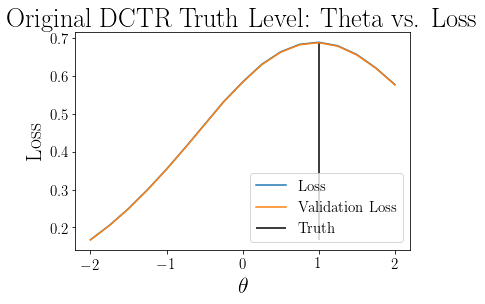

In [34]:
plt.title("Original DCTR Truth Level: Theta vs. Loss")
plt.plot(thetas, lvals_T_original, label='Loss')
plt.plot(thetas, vlvals_T_original, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_T_original),
           ymax=np.max(vlvals_T_original),
           label='Truth')
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-OriginalDCTR-Truth-Level:-Theta-vs-Loss.png")
plt.show()

In [35]:
f = sp.interpolate.interp1d(thetas, lvals_T_original, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999906046123


#### Detector Level Scan

In [36]:
def my_loss_wrapper_D_original(val=0,
                               reweight_type='DCTR',
                               loss='MSE',
                               batch_size=1000):
    def my_loss(y_true, y_pred):
        y_true = tf.gather(y_true, np.arange(batch_size))
        x_T = tf.gather(y_true, [1], axis=1)  # sim event truth for reweighting
        y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
        theta_prime = val

        if reweight_type == 'DCTR':
            # NN (DCTR) reweight
            weights = reweight_original(x_T, theta_prime)
        elif reweight_type == 'analytical':
            # analytical reweight
            weights = analytical_reweight(x_T, theta_prime)
        else:
            raise ValueError(
                "reweight_type must be set to 'DCTR' or 'analytical'")

        if loss == 'MSE':
            # Mean Squared Loss
            t_loss = y_true * (y_true - y_pred)**2 + (weights) * (
                1. - y_true) * (y_true - y_pred)**2
        elif loss == 'categorical_crossentropy':
            # Categorical Cross-Entropy Loss
            # Clip the prediction value to prevent NaN's and Inf's
            epsilon = K.epsilon()
            y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

            t_loss = -((y_true) * K.log(y_pred) + weights *
                       (1 - y_true) * K.log(1 - y_pred))
        else:
            raise ValueError(
                "loss must be set to 'MSE' or 'categorical_crossentropy'")
        return K.mean(t_loss)

    return my_loss

In [37]:
lvals_D_original = []
vlvals_D_original = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_original.compile(optimizer='adam',
                           loss=my_loss_wrapper_D_original(
                               theta,
                               loss='categorical_crossentropy',
                               batch_size=batch_size),
                           metrics=['accuracy'])

    history = model_original.fit(np.array(X_train_D),
                                 y_train_D,
                                 epochs=100,
                                 batch_size=batch_size,
                                 validation_data=(np.array(X_test_D),
                                                  y_test_D),
                                 verbose=0,
                                 callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D_original += [min_lval]
    vlvals_D_original += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta =  -2.0
loss:  0.248261194601655
val_loss:  0.24713334779441357


Testing theta =  -1.75
loss:  0.2848392647057772
val_loss:  0.28416662842035295


Testing theta =  -1.5
loss:  0.325585941940546
val_loss:  0.32523365145921707


Testing theta =  -1.25
loss:  0.3698392617702484
val_loss:  0.3697037089765072


Testing theta =  -1.0
loss:  0.4164174665212631
val_loss:  0.4163958473801613


Testing theta =  -0.75
loss:  0.46468639048933985
val_loss:  0.464696556776762


Testing theta =  -0.5
loss:  0.5136824157238007
val_loss:  0.5136367219388485


Testing theta =  -0.25
loss:  0.5617381266355514
val_loss:  0.5615355648994446


Testing theta =  0.0
loss:  0.6019588934779168
val_loss:  0.6015764487981796


Testing theta =  0.25
loss:  0.6376549385786057
val_loss:  0.6370626638531685


Testing theta =  0.5
loss:  0.661820728123188
val_loss:  0.661127767264843


Testing theta =  0.75
loss:  0.675768099963665
val_loss:  0.6748576496243477


Testing theta =  1.0
loss:  0.6789026729

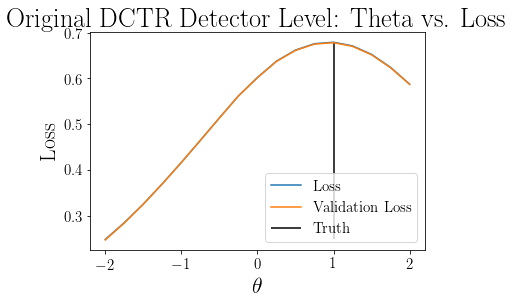

In [38]:
plt.plot(thetas, lvals_D_original, label='Loss')
plt.plot(thetas, vlvals_D_original, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D_original),
           ymax=np.max(vlvals_D_original),
           label='Truth')
plt.title("Original DCTR Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-OriginalDCTR-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [39]:
f = sp.interpolate.interp1d(thetas, lvals_D_original, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999892666462


#### Comparison Plot

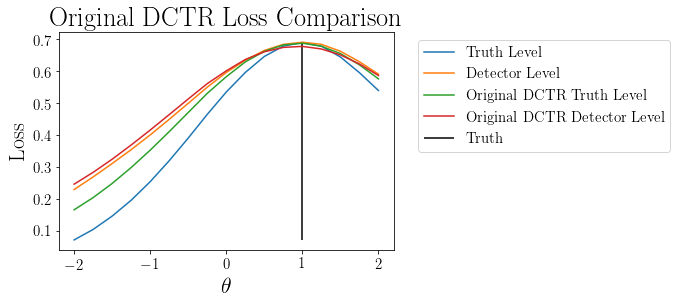

In [40]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D, label='Detector Level')

plt.plot(thetas, vlvals_T_original, label='Original DCTR Truth Level')
plt.plot(thetas, vlvals_D_original, label='Original DCTR Detector Level')

plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(
    theta1_param,
    ymin=np.min(vlvals_T + vlvals_D + vlvals_T_original + vlvals_D_original),
    ymax=np.max(vlvals_T + vlvals_D + vlvals_T_original + vlvals_D_original),
    label='Truth')
plt.title("Original DCTR Loss Comparison")
plt.legend(bbox_to_anchor=(1.05, 1.0))
# plt.savefig(
#     "GaussianAltFit-1D-ThetaDependentDetectorEffects-OriginalDCTR-Loss-Comparison.png",
#     bbox_inches='tight')
plt.show()

We can see that both the original DCTR Truth and Detector Levels are flatter than the actual Truth and Detector Levels respecively.

# More complex, uneven detector effects

To apply detector effects here, each event's primary truth observable $x_{T,i,0}$in the sample is smeared by shifting by $Z_{i}$ from $Z = \mathcal{N}((x_{T,i,1})^2,(x_{T,i,1})^2)$ ,where the square of the secondary truth observable $x_{T,i,1}$ represents the some shifting bias as well as smearing. Thus: $x_{D,i} = x_{T,i,0} + Z_{i}$

In [41]:
# Generate detector level by smearing truth

X0_val_D_new = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                         for x in X0_val_T])  # Detector smearing
X1_val_D_new = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                         for x in X1_val_T])  # Detector smearing

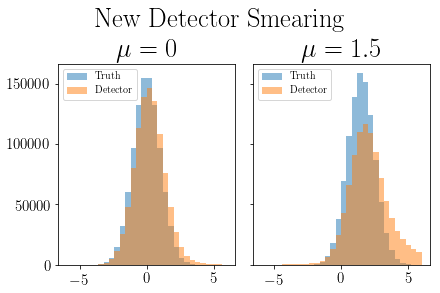

In [42]:
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('New Detector Smearing')
axs[0].set_title('$\mu=0$')
axs[0].hist(X0_val_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(X0_val_D_new, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc='upper left')
axs[1].set_title('$\mu={}$'.format(mu1))
axs[1].hist(X1_val_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(X1_val_D_new, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc='upper left')
fig.show()

Note that the same validation weights will work here as reweighting only depends only on truth, which is determined by $(x_{T,i,0},x_{T,i,1})$ and not how the detector effects are applied, so long these effects depend solely on truth in some way.

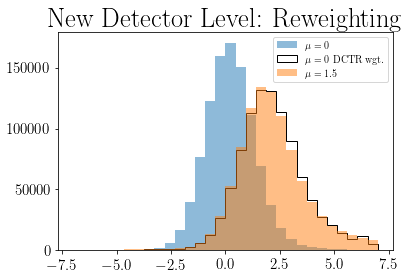

In [43]:
bins = np.linspace(-7, 7, 31)
plt.hist(X0_val_D_new, bins=bins, alpha=0.5, label=r'$\mu=0$')
plt.hist(X0_val_D_new,
         bins=bins,
         label=r'$\mu=0$ DCTR wgt.',
         weights=weights_val,
         histtype='step',
         color='k')
plt.hist(X1_val_D_new, bins=bins, alpha=0.5, label=r'$\mu={}$'.format(mu1))
plt.legend(prop=fontP)
plt.title("New Detector Level: Reweighting")
#plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-New-Detector-Level:Reweighting.png")
plt.show()

## Scanning with New Effects

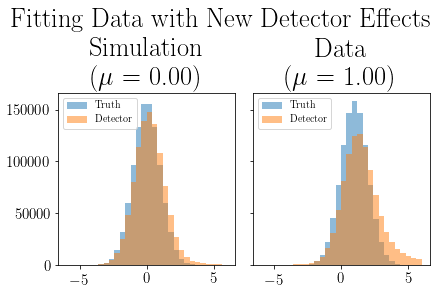

In [44]:
N = 10**6
theta0_param = 0  # this is the simulation ... N.B. this notation is reversed from above!
theta1_param = 1  # this is the data (the target)
sigma = 1.  # standard Gaussian width
# epsilon = sigma / 2  # Smearing width

theta0_T_0 = np.random.normal(theta0_param, sigma, N)  # Truth Level Data
theta0_T_1 = np.random.normal(0, nu(theta0_param), N)
theta0_T = np.stack((theta0_T_0, theta0_T_1), axis=-1)

theta0_D = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                     for x in theta0_T])  # Detector smearing

theta0 = np.hstack([theta0_T, np.expand_dims(theta0_D, axis=-1)])

theta1_T = np.random.normal(theta1_param, sigma, N)
theta1_T_ep = np.random.normal(0, nu(theta1_param), N)
theta1_T = np.stack((theta1_T, theta1_T_ep), axis=-1)

theta1_D = np.array([(x[0] + np.random.normal(x[1]**2, x[1]**2))
                     for x in theta1_T])  # Detector smearing

theta1 = np.hstack([theta1_T, np.expand_dims(theta1_D, axis=-1)])

bins = np.linspace(-6, 6, 31)

fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
fig.suptitle('Fitting Data with New Detector Effects')

axs[0].set_title("Simulation\n($\mu$ = {:.2f})".format(theta0_param))
axs[0].hist(theta0_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[0].hist(theta0_D, bins=bins, alpha=0.5, label='Detector')
axs[0].legend(prop=fontP, loc='upper left')

axs[1].set_title("Data\n($\mu$ = {:.2f})".format(theta1_param))
axs[1].hist(theta1_T[:, 0], bins=bins, alpha=0.5, label='Truth')
axs[1].hist(theta1_D, bins=bins, alpha=0.5, label='Detector')
axs[1].legend(prop=fontP, loc='upper left')

# fig.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-Fitting-Data-with-New-Detector-Effects.png")
plt.show()

labels0 = np.zeros(len(theta0))
labels1 = np.ones(len(theta1))

xvals = np.concatenate([theta0, theta1])
yvals = np.concatenate([labels0, labels1])

X_train, X_test, y_train, y_test = train_test_split(xvals,
                                                    yvals,
                                                    test_size=0.5)
X_train_theta, y_train_theta = shuffle(xvals, yvals)

X_train_T, y_train_T = np.copy(X_train[:, :2]), y_train
X_test_T, y_test_T = np.copy(X_test[:, :2]), y_test
X_train_theta_T, y_train_theta_T = np.copy(X_train_theta[:, :2]), y_train_theta

#' Erasing' Truth level for data, we can't actually observe this
X_train[:, :2][y_train == 1], X_test[:, :2][y_test == 1] = 0., 0.
X_train_theta[:, :2][y_train_theta == 1] = 0.

# 'hiding' truth level for simulation in expected model output (used in reweighting)
X_train_D, y_train_D = X_train[:, 2], np.hstack(
    [np.expand_dims(y_train, axis=-1), X_train[:, :2]])
X_test_D, y_test_D = X_test[:, 2], np.hstack(
    [np.expand_dims(y_test, axis=-1), X_test[:, :2]])

X_train_theta_D, y_train_theta_D = X_train_theta[:, 1], np.hstack(
    [np.expand_dims(y_train_theta, axis=-1), X_train_theta[:, :2]])

Notice how detector smearing and right-shifting is more intense for "Data".

In [45]:
lvals_D_new = []
vlvals_D_new = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_D.compile(optimizer='adam',
                    loss=my_loss_wrapper_D(theta,
                                           loss='categorical_crossentropy',
                                           batch_size=batch_size),
                    metrics=['accuracy'])

    history = model_D.fit(np.array(X_train_D),
                          y_train_D,
                          epochs=100,
                          batch_size=batch_size,
                          validation_data=(np.array(X_test_D), y_test_D),
                          verbose=0,
                          callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D_new += [min_lval]
    vlvals_D_new += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass
print(lvals_D)

Testing theta =  -2.0
loss:  0.1521508372053504
val_loss:  0.15258769451081752


Testing theta =  -1.75
loss:  0.18638191071152688
val_loss:  0.1867772781699896


Testing theta =  -1.5
loss:  0.22645251600444316
val_loss:  0.22666577646136285


Testing theta =  -1.25
loss:  0.2702040612846613
val_loss:  0.2707497564256191


Testing theta =  -1.0
loss:  0.3205508323609829
val_loss:  0.3211451207101345


Testing theta =  -0.75
loss:  0.3772730627655983
val_loss:  0.3778550264239311


Testing theta =  -0.5
loss:  0.4396205525696278
val_loss:  0.44004094168543817


Testing theta =  -0.25
loss:  0.5046619412600994
val_loss:  0.5049884621500969


Testing theta =  0.0
loss:  0.5656839823126792
val_loss:  0.5657427814602852


Testing theta =  0.25
loss:  0.6172166193723678
val_loss:  0.6170291694402694


Testing theta =  0.5
loss:  0.6574955837726593
val_loss:  0.6574686200022698


Testing theta =  0.75
loss:  0.6823754349946975
val_loss:  0.6831610521674156


Testing theta =  1.0
loss:  0.690

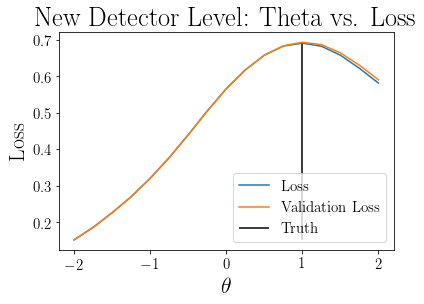

In [46]:
plt.plot(thetas, lvals_D_new, label='Loss')
plt.plot(thetas, vlvals_D_new, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D_new),
           ymax=np.max(lvals_D_new),
           label='Truth')
plt.title("New Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-New-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [47]:
f = sp.interpolate.interp1d(thetas, lvals_D_new, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  0.9999999928244057


### Comparison Plot

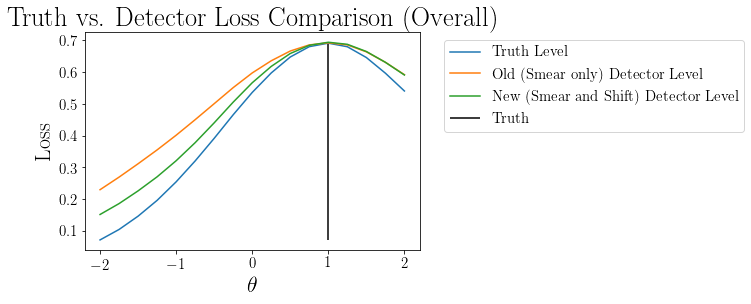

In [48]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D, label='Old (Smear only) Detector Level')
plt.plot(thetas, vlvals_D_new, label='New (Smear and Shift) Detector Level')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(vlvals_T + vlvals_D + vlvals_D_new),
           ymax=np.max(vlvals_T + vlvals_D + vlvals_D_new),
           label='Truth')
plt.title("Truth vs. Detector Loss Comparison (Overall)")
plt.legend(bbox_to_anchor=(1.05, 1.0))
# plt.savefig(
#     "GaussianAltFit-1D-ThetaDependentDetectorEffects-Truth-vs-Detector-Loss-Comparison-Overall.png",
#     bbox_inches='tight')
plt.show()

## Compare to Original DCTR
See how incorrect the fit is if we ignore the secondary truth observable and use the original DCTR.

In [49]:
lvals_D_original_new = []
vlvals_D_original_new = []

for theta in thetas:
    print("Testing theta = ", theta)
    model_original.compile(optimizer='adam',
                           loss=my_loss_wrapper_D_original(
                               theta,
                               loss='categorical_crossentropy',
                               batch_size=batch_size),
                           metrics=['accuracy'])

    history = model_original.fit(np.array(X_train_D),
                                 y_train_D,
                                 epochs=100,
                                 batch_size=batch_size,
                                 validation_data=(np.array(X_test_D),
                                                  y_test_D),
                                 verbose=0,
                                 callbacks=[earlystopping])

    min_lval = history.history['loss'][np.argmin(history.history['val_loss'])]
    min_vlval = np.min(history.history['val_loss'])

    lvals_D_original_new += [min_lval]
    vlvals_D_original_new += [min_vlval]

    print("loss: ", min_lval)
    print("val_loss: ", min_vlval)
    print("\n")
    pass

Testing theta =  -2.0
loss:  0.21473089565336703
val_loss:  0.21397073024511337


Testing theta =  -1.75
loss:  0.25003744001686573
val_loss:  0.24970262940227986


Testing theta =  -1.5
loss:  0.2896064716428518
val_loss:  0.2894557816386223


Testing theta =  -1.25
loss:  0.33297368291020396
val_loss:  0.3331043848991394


Testing theta =  -1.0
loss:  0.3790859500467777
val_loss:  0.37919610539078713


Testing theta =  -0.75
loss:  0.42750628635287286
val_loss:  0.42756807133555413


Testing theta =  -0.5
loss:  0.47731640410423276
val_loss:  0.47738902059197424


Testing theta =  -0.25
loss:  0.5270888867974282
val_loss:  0.5271404972970486


Testing theta =  0.0
loss:  0.5702974451184273
val_loss:  0.5703287009596825


Testing theta =  0.25
loss:  0.6101303067207337
val_loss:  0.6101515084505081


Testing theta =  0.5
loss:  0.6400576770305634
val_loss:  0.6400264260768891


Testing theta =  0.75
loss:  0.6607650703191758
val_loss:  0.6606376537680626


Testing theta =  1.0
loss:  

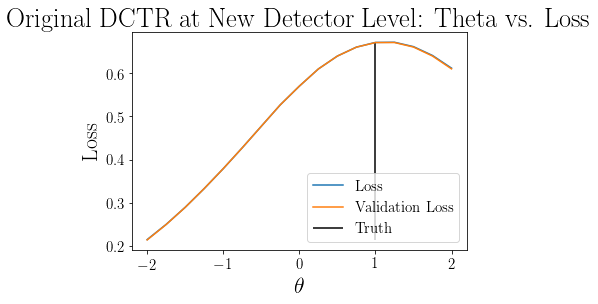

In [50]:
plt.plot(thetas, lvals_D_original_new, label='Loss')
plt.plot(thetas, vlvals_D_original_new, label='Validation Loss')
plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(lvals_D_original_new),
           ymax=np.max(vlvals_D_original_new),
           label='Truth')
plt.title("Original DCTR at New Detector Level: Theta vs. Loss")
plt.legend()
# plt.savefig("GaussianAltFit-1D-ThetaDependentDetectorEffects-OriginalDCTR-Detector-Level:-Theta-vs-Loss.png")
plt.show()

In [51]:
f = sp.interpolate.interp1d(thetas, lvals_D_original_new, fill_value="extrapolate")

print("Interpolated Maximum: ",
      sp.optimize.minimize(lambda x: -f(x), x0=0)['x'][0])

Interpolated Maximum:  1.0940369802219956


We can see that when the orignal DCTR is used in reweighting at the "new" detector level, the peak is shifted incorrectly to the right.

### Comparison Plot

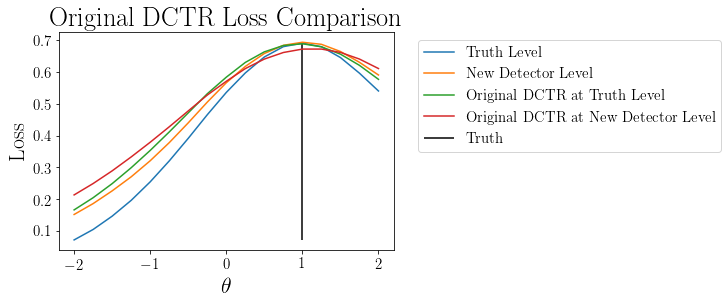

In [52]:
plt.plot(thetas, vlvals_T, label='Truth Level')
plt.plot(thetas, vlvals_D_new, label='New Detector Level')

plt.plot(thetas, vlvals_T_original, label='Original DCTR at Truth Level')
plt.plot(thetas,
         vlvals_D_original_new,
         label='Original DCTR at New Detector Level')

plt.xlabel(r'$\theta$')
plt.ylabel('Loss')
plt.vlines(theta1_param,
           ymin=np.min(vlvals_T + vlvals_D_new + vlvals_T_original +
                       vlvals_D_original_new),
           ymax=np.max(vlvals_T + vlvals_D_new + vlvals_T_original +
                       vlvals_D_original_new),
           label='Truth')
plt.title("Original DCTR Loss Comparison")
plt.legend(bbox_to_anchor=(1.05, 1.0))
# plt.savefig(
#     "GaussianAltFit-1D-ThetaDependentDetectorEffects-OriginalDCTR-Loss-Comparison.png",
#     bbox_inches='tight')
plt.show()